In [ ]:
## variables for DynamoDB : text, date, id, company, geo

## companies to choose : American airlines, British Airways


# transfo AWS : mentions ==1, remove http, remove retweets, remove None text, check mention == company, 

# transfo here : remove http, remove None text, mentions==1, remove RT, convert companies'names, check mention == company

In [ ]:
## remove .. at the end because adds bias - > ex of the missing bag

## Packages

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.utils import resample
import re
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from wordcloud import WordCloud
from nltk.corpus import stopwords
from keras.models import model_from_json 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
#from keras.layers import Dense
from keras.backend import clear_session
import pickle 

Using TensorFlow backend.
/anaconda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.23) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Data overview

In [3]:
raw_data=pd.read_csv('Tweets.csv')

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [ ]:
## only 32 and 40 non null objects for 'airline_sentiment_gold' and 'negativereason_gold'
## same for tweet_coord

In [ ]:
raw_data.columns

In [ ]:
sns.countplot(raw_data['airline_sentiment'])

In [33]:
raw_data['negativereason'].unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage',
       'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

In [26]:
pd.options.display.max_colwidth=100
raw_data['text'].sample(5,random_state=1)

8515                                                   @JetBlue I'll pass along the advice. You guys rock!!
3439    @united I sent you a dm with my file reference number.. I just want to know if someone has locat...
6439                                     @SouthwestAir Black History Commercial is really sweet. Well done.
5112    @SouthwestAir why am I still in Baltimore?! @delta is doing laps around us and laughing about it...
5645               @SouthwestAir SEA to DEN. South Sound Volleyball team on its way! http://t.co/tN5cXCld6M
Name: text, dtype: object

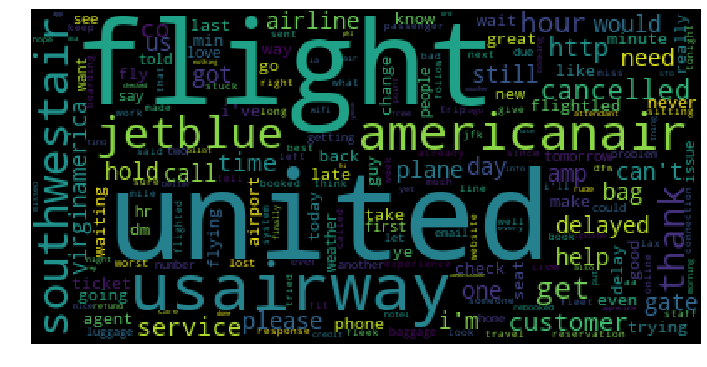

In [27]:
text=raw_data['text'].to_string().lower()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## data cleaning

In [28]:
comp_mentions={'Delta':'@Delta','Southwest':'@SouthwestAir',
               'US Airways':'@USAirways','American':'@AmericanAir',
               'Virgin America':'@VirginAmerica','United':'@united'}

authorized_mentions=['virginamerica','united','southwestair','usairways','americanair','deltaassist']


def keep_informative_cols_lines(data):
        cols=['airline_sentiment','airline_sentiment_confidence','airline','text','negativereason']
        data.dropna(subset=['text'],axis=0,inplace=True)
        return(data[cols])
    
    
def remove_several_mentions(data):
    data['nb_mentions']=data['text'].apply(lambda z :z.count('@') if z else 0)
    data=data[data.nb_mentions==1]
    data.reset_index(drop=True,inplace=True)
    return(data)


def remove_links(x):
        if x:
            if 'http' in x:
                regex=re.compile('(.+)\shttp.+')
                m=regex.search(str(x))
                if m:
                    return(m.group(1))
            else:
                return(x)
def remove_links_data(data):
    data['text']=data['text'].apply(lambda z: remove_links(z))
    return(data)

def get_mention(x):
    regex=re.compile('@(\w+)')
    m=regex.search(str(x))
    if m:
        return(m.group(1))

def check_mention(data):
    data['mention']=data['text'].apply(lambda z :get_mention(z).lower())
    data=data[data.mention.isin(authorized_mentions)]
    data.reset_index(drop=True,inplace=True)
    return(data)
            
def rebalance_data(data):
    minority_1=data[data.airline_sentiment=='positive']
    minority_2=data[data.airline_sentiment=='neutral']

    majority=data[data.airline_sentiment=='negative']
    df_minority_upsampled_1 = resample(minority_1, 
                                 replace=True,     
                                 n_samples=len(majority),    
                                 random_state=123)
    df_minority_upsampled_2 = resample(minority_2, 
                                 replace=True,     
                                 n_samples=len(majority),    
                                 random_state=123)
    data_bal=pd.concat([df_minority_upsampled_1,df_minority_upsampled_2,majority])
    data_bal.reset_index(inplace=True,drop=True)
    data_bal.dropna(subset=['text'],axis=0,inplace=True)
    return(data_bal)


def remove_comp_names(data):
    data['text']=data.apply(lambda row: row['text'].replace(comp_mentions[row['airline']],'FIRM'),axis=1)
    return(data)

In [29]:
data=pd.read_csv('Tweets.csv')
data=keep_informative_cols_lines(data)
data=remove_several_mentions(data)
data=check_mention(data)
data=remove_comp_names(data)
data=remove_links_data(data)
data=rebalance_data(data)

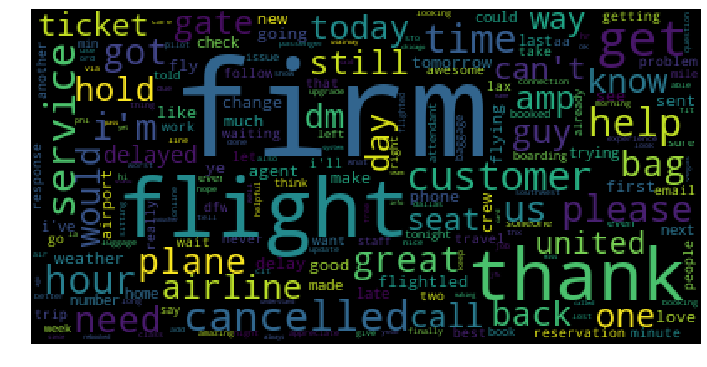

In [30]:
text=data['text'].to_string().lower()
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
data['nb_words']=data['text'].apply(lambda z: z.count(' ') if z else 0)

In [ ]:
sns.countplot(data['nb_words'])

## Topic classif

In [ ]:
plt.figure(figsize=(20,12))
ax=sns.countplot(data['negativereason'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
np.max(data['negativereason'].value_counts())

In [39]:
df_minorities=[]
df_majority=data[data.negativereason==np.argmax(data['negativereason'].value_counts())]
for reason in list((data['negativereason'].dropna()).drop_duplicates()):
    if reason!=np.argmax(data['negativereason'].value_counts()):
        df_minority = data[data['negativereason']==reason]
        df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=2429,    # to match majority class
                                     random_state=123)
        df_minorities.append(df_minority_upsampled)
data_topic=pd.concat([pd.concat(df_minorities),df_majority])

In [ ]:
pd.options.display.max_colwidth=200
data_topic[['text','negativereason']].sample(10)

In [ ]:
plt.figure(figsize=(20,12))
ax=sns.countplot(data_topic['negativereason'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

### neural_net

In [40]:
data_topic['negativereason']=data_topic['negativereason'].apply(lambda z: "Can't Tell" if z=='Bad Flight' else z)
data_topic['negativereason']=data_topic['negativereason'].apply(lambda z: "Luggage" if ((z=='Lost Luggage')or (z=='Damaged Luggage')) else z)

In [41]:
df_minorities=[]
df_majority=data_topic[data_topic.negativereason==np.argmax(data_topic['negativereason'].value_counts())]
for reason in list((data_topic['negativereason'].dropna()).drop_duplicates()):
    if reason!=np.argmax(data_topic['negativereason'].value_counts()):
        df_minority = data_topic[data_topic['negativereason']==reason]
        df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123)
        df_minorities.append(df_minority_upsampled)
data_topic_b=pd.concat([pd.concat(df_minorities),df_majority])

In [42]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
data_topic_b = shuffle(data_topic_b)

In [43]:
train_size = int(len(data_topic_b) * .8)
 
train_tweets = data_topic_b['text'][:train_size]
train_reason = data_topic_b['negativereason'][:train_size]
 
test_tweets = data_topic_b['text'][train_size:]
test_reason = data_topic_b['negativereason'][train_size:]

In [44]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_tweets)
 
X_train = tokenizer.texts_to_sequences(train_tweets)
X_test = tokenizer.texts_to_sequences(test_tweets)
X_train = sequence.pad_sequences(X_train, maxlen=35)
X_test = sequence.pad_sequences(X_test, maxlen=35)
 
encoder = LabelBinarizer()
encoder.fit(train_reason)
y_train = encoder.transform(train_reason)
y_test = encoder.transform(test_reason)

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31091, 35) (7773, 35) (31091, 8) (7773, 8)


In [46]:
text_labels = encoder.classes_

In [47]:
# keras for topic classif
X=data_topic_b['text']
y=np.array(pd.get_dummies(data_topic_b['negativereason']))
max_words = 35
max_features= 10000

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27204,) (11660,) (27204, 8) (11660, 8)


In [48]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [49]:
def get_model(max_features, embed_dim):
    clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))  
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)
    plot_model_history(model_history)
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
Total params: 1,081,208
Trainable params: 1,081,208
Non-trainable params: 0
_________________________________________________________________
None
Train on 31091 samples, validate on 7773 samples
Epoch 1/6
 - 58s - loss: 1.1725 - acc: 0.5989 - val_loss: 0.4666 - val_acc: 0.8831
Epoch 2/6
 - 55s - loss: 0.3299 - acc: 0.9067 - val_loss: 0.2226 - val_acc: 0.9367
Epoch 3/6
 - 56s - loss: 0.1605 - acc: 0.9562 - val_loss: 0.1483 - val_acc: 0.9591
Epoch 4/6
 - 55s - loss: 0.0964 - acc: 0.9732 - val_loss: 0.1209 - val_acc: 0.9671
Epoch 5/6


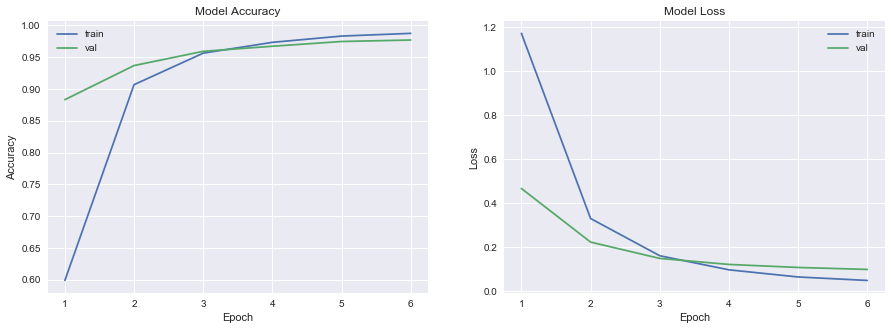

In [33]:
epochs=6
batch_size=128
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

In [35]:
text_labels

array(["Can't Tell", 'Cancelled Flight', 'Customer Service Issue',
       'Flight Attendant Complaints', 'Flight Booking Problems',
       'Late Flight', 'Luggage', 'longlines'],
      dtype='<U27')

In [ ]:
# idea : group luggage issues
# idea : group Can't tell and bad flight
# 92,97% avant
# 93,32% après regroupement mais classes unbalanced
# 97 % après regroupement et balanced classes
# 97,7% avec tf-idf

In [38]:
from sklearn.metrics import confusion_matrix
predictions=model.predict_classes(X_test)
confusion_matrix(np.array([np.argmax(y_test[i]) for i in range(len(y_test))]),predictions)

array([[956,   1,   5,   2,   4,   7,   3,   4],
       [  6, 988,   4,   0,   1,   0,   3,   0],
       [ 42,  13, 909,   9,  16,  12,   3,   2],
       [  0,   0,   4, 958,   2,   0,   0,   0],
       [  0,   0,   1,   0, 953,   0,   0,   2],
       [  4,   2,   6,   1,   2, 927,   2,   2],
       [  6,   1,   3,   1,   2,   2, 941,   0],
       [  0,   0,   0,   0,   0,   0,   0, 961]])

In [43]:
#classes=list(set(data_topic['negativereason'].unique()))
sentences_test=['firm perfect, no one outside of the plane to help, I pay $840 to fly from Las Vegas to NW Arkansas, and AA…',
               "firm seriously disappointed with the delay that occurred tonight on my flight because of a lack of available crew.",
               "firm But unfortunately your company wasn’t as understanding, and made me waste hours of my time. I spoke wi…",
               "firm hello, I have some elderly clients on Flight 3592 to ORD  today - currently departure is 4 hours delay…",
              "firm thanks for locating the missing bag and for the much appreciated surprise on the ticket for my last",
              "thank you firm for one of the worst travel days ever yesterday 😒",
               "thank you firm my flight today delayed 6.5 hours for mechanical and pilot issues. Haven’t provided passenge…",
               "firm my connecting flight got canceled and new options you are offering is later than the time I need to be…"]
sentence_test=tokenizer.texts_to_sequences(sentences_test)
sentence_test=sequence.pad_sequences(sentence_test, maxlen=max_words)
predicted=model.predict_classes(sentence_test)
[text_labels[predicted[i]] for i in range(len(predicted))]

["Can't Tell",
 'Late Flight',
 'Flight Attendant Complaints',
 'Late Flight',
 'Luggage',
 "Can't Tell",
 'Late Flight',
 'Cancelled Flight']

In [44]:
# ok let's save this model, it looks quite accurate
model_json = model.to_json() 
with open("topic_classif_airlines.json", "w") as json_file: 
    json_file.write(model_json)
model.save_weights("topic_classif_airlines.h5") 
with open("topic_classif_airlines.pickle", "wb") as handle: 
    pickle.dump(tokenizer, handle, protocol = 2)

### lda

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=max_features)
tf = tf_vectorizer.fit_transform(data_topic['text'])
tf_feature_names = tf_vectorizer.get_feature_names()
lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
no_top_words=10
print_top_words(lda, tf_feature_names, no_top_words)

## feature engineering sentiment

In [ ]:
# 0 for negative, 1 for neutral, 2 for positive
# to test : put nb_words as explanatory var and confidence

In [ ]:
# we want to remove the tweets with nb_mentions!=1

In [34]:
X=data['text']
y=np.array(pd.get_dummies(data['airline_sentiment']))
max_words = 35
max_features= 10000

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15452,) (6623,) (15452, 3) (6623, 3)


In [35]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

## training

In [36]:
import keras.backend as K
from random import seed
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
batch_size = 128
epochs = 6

In [37]:
def get_model(max_features, embed_dim):
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))  
    model.add(LSTM(embed_dim, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                          epochs=epochs, batch_size=batch_size, verbose=2)
    plot_model_history(model_history)
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 35, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 1,080,703
Trainable params: 1,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 15452 samples, validate on 6623 samples
Epoch 1/6
 - 32s - loss: 0.7861 - acc: 0.6392 - val_loss: 0.4562 - val_acc: 0.8312
Epoch 2/6
 - 30s - loss: 0.3376 - acc: 0.8784 - val_loss: 0.3242 - val_acc: 0.8834
Epoch 3/6
 - 29s - loss: 0.1987 - acc: 0.9330 - val_loss: 0.2799 - val_acc: 0.9041
Epoch 4/6
 - 28s - loss: 0.1448 - acc: 0.9519 - val_loss: 0.2743 - val_acc: 0.9138
Epoch 5/6


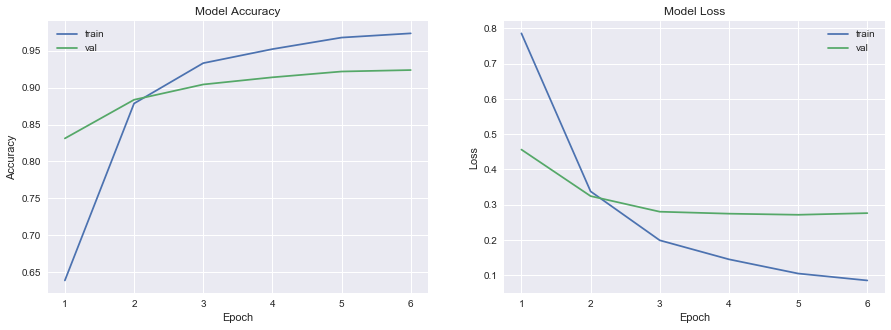

In [38]:
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

## predictions on test_set

In [ ]:
sentences_test=['firm perfect, no one outside of the plane to help, I pay $840 to fly from Las Vegas to NW Arkansas, and AA…',
               "firm seriously disappointed with the delay that occurred tonight on my flight because of a lack of available crew.",
               "firm But unfortunately your company wasn’t as understanding, and made me waste hours of my time. I spoke wi…",
              "always a pleasure to fly with firm",
               "firm fantastic. that’s helpful info. thanks!",
              "Looking forward to flying firm later today #americandream #americanairlines what do you have to do to get a free upgrade 😉",
              "gate to gate wifi is an improvement. ht firm for getting that setup. #technology #business #aa2503 #travel",
              "firm keep on amazing me",
               "firm hello, I have some elderly clients on Flight 3592 to ORD  today - currently departure is 4 hours delay…",
              "firm thanks for locating the missing bag and for the much appreciated surprise on the ticket for my last",
              "thank you firm for one of the worst travel days ever yesterday 😒",
              "However, shoutout for the amazing customer care firm has shown us. From making sure my wife and I sat toget…",
              "Non-stop #Paris to #Miami roundtrip #CheapFlights €291 on firm ",
            "firm Do you provide animal free flights?",
               "firm the crew on flight 1300 Fll-Clt has been such a delight, they went above and beyond to take care of my…",
               "@AmericanAir I will make sure they contact you when they land. Delays made them miss a full day of their Honeymoon.…"]
sentence_test=tokenizer.texts_to_sequences(sentences_test)
sentence_test=sequence.pad_sequences(sentence_test, maxlen=max_words)
predicted=model.predict_classes(sentence_test)
actual=np.array([0,0,0,2,2,1,2,2,0,2,0,2,1,1,2,0])
print(predicted)
print(np.sum([actual[i]==predicted[i] for i in range(len(actual))])/len(actual))

In [ ]:
model.predict_proba(sentence_test)

In [ ]:
predictions=model.predict_classes(X_test)
print(confusion_matrix(np.array([np.argmax(y_test[i]) for i in range(len(y_test))]),predictions))

## Save model

In [ ]:
model_json = model.to_json() 
with open("sentiment_airlines.json", "w") as json_file: 
    json_file.write(model_json)
model.save_weights("sentiment_airlines.h5") 
with open("tokenizer_model_airlines.pickle", "wb") as handle: 
    pickle.dump(tokenizer, handle, protocol = 2)

## Test running model locally

In [ ]:
json_file = open('sentiment_airlines.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("sentiment_airlines.h5")
print("Loaded model from disk")
with open("tokenizer_model_airlines.pickle", "rb") as handle:
    tokenizer_test=pickle.load(handle)
sentence_local=tokenizer_test.texts_to_sequences(sentences_test)
sentence_local=sequence.pad_sequences(sentence_local, maxlen=max_words)
predicted_local=loaded_model.predict_classes(sentence_local)

In [ ]:
print(predicted==predicted_local)

In [ ]:
## ok seems to work!

## Test calling model via AWS API

In [ ]:
import requests

In [ ]:
m='bkdjcb cdbckdcb ckd bcdkb'

In [ ]:
[m]

In [ ]:
url="https://0tk2lljzxl.execute-api.us-east-1.amazonaws.com/default/api_sentiment"
predicted_api=[]
for s in sentences_test:
    payload={'text':s}
    r=requests.get(url,params=payload)
    predicted_api.append(int(r.json()[0]))

In [ ]:
r=requests.get(url,params=payload)

In [ ]:
r=requests.get(url,params=payload,headers={'x-api-key':'kbq1TjIrMi5qvYwgmn62O4BJyi8nINs25ej00YJ2'})

In [ ]:
r.content

In [ ]:
type(r.json()[0])

In [ ]:
r.status_code

In [ ]:
{'x_api_key':'kbq1TjIrMi5qvYwgmn62O4BJyi8nINs25ej00YJ2'}

In [ ]:
r.content

In [ ]:
predicted_api

In [ ]:
print(predicted==predicted_api)